## To-Dos

- Add override capaility
- Add Covid19 scenarios

In [86]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt
import seaborn as sns

import humanize

sns.set_style('white')
%matplotlib inline

In [87]:
axis_color = "0.4"
non_accent_light = "#dbdbdb"
non_accent_medium = "#bdbdbd"
non_accent_dark = "#a8a8a8"
accent = "#4599ff"
palette = sns.color_palette([non_accent_medium,accent])

In [88]:
def format_chart_axes(title,axes,x_label_format='{:,.1f}',x_label_scale=1,y_label_format='{:,.1f}',y_label_scale=1,color="black"):
    plt.title(title,y=1.05, color=color)

    axes.set_xticks(axes.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    axes.set_xticklabels([x_label_format.format(x) for x in (axes.get_xticks()/x_label_scale).tolist()])
    
    axes.set_yticks(axes.get_yticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    axes.set_yticklabels([y_label_format.format(x) for x in (axes.get_yticks()/y_label_scale).tolist()])

    axes.spines['bottom'].set_color(color)
    axes.xaxis.label.set_color(color)
    axes.tick_params(axis='x', colors=color)

    axes.spines['left'].set_color(color)
    axes.yaxis.label.set_color(color)
    axes.tick_params(axis='y', colors=color)

    sns.despine()    

## Data processing

In [89]:
econ_df = pd.DataFrame()
gambling_df = pd.DataFrame()
tnl_df  = pd.DataFrame()
hist_df = pd.DataFrame()

In [90]:
temp = pd.read_csv('./data/ABMI-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','GDP']

temp['GDP'] = pd.to_numeric(temp['GDP'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['GDP growth'] = temp['GDP'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [91]:
temp = pd.read_csv('./data/QWND-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','disposable income']

temp['disposable income'] = pd.to_numeric(temp['disposable income'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['disposable income growth'] = temp['disposable income'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [92]:
temp = pd.read_csv('./data/marketdata.csv')
temp.index = temp['Year']
temp = temp.drop('Year',axis=1)


gambling_df = pd.concat(
    [gambling_df,
     temp[[
        'Gambling GGY',
        'Total gambling participation']].loc[:2019]
    ]
)

gambling_df.columns = [
    'gambling GGY',
    'gambling players']

        
tnl_df = pd.concat(
    [tnl_df,
     temp[['TNL GGY',
           'TNL participation']].loc[:2019]
    ]
)

tnl_df.columns = [
    'TNL GGY', 
    'TNL players']

In [93]:
hist_df = pd.merge(
        econ_df,
        gambling_df,
        left_index=True,
        right_index=True,
        how='outer',
)

hist_df = pd.merge(
        hist_df,
        tnl_df,
        left_index=True,
        right_index=True,
        how='outer',
)

hist_df.index = hist_df.index.set_names('year')

## Monte Carlo Simulation

In [94]:
iterations = 750
years_to_project = 10
initial_year = 2020

In [95]:
GDP_yoy_change_mean = 0.024383720592148272        #Historical average of YoY growth in the period from 1956 to 2019
GDP_yoy_change_stdev = 0.020191051459338794     #Historical stdev of YoY growth in the period from 1956 to 2019

TNL_shareDI_yoy_change_mean = 0.0003997407239658791
TNL_shareDI_yoy_change_stdev = 0.06419624024568973

In [96]:
projections_df = pd.DataFrame()

for n in range(iterations):
    # Empty temporary dataframe to populate with this iteration and then append to projections dataframe
    tmp_df = pd.DataFrame()

    # Generate normally distributed values of input variables for this iteration
    projected_GDP_growth = np.random.normal(GDP_yoy_change_mean, GDP_yoy_change_stdev, years_to_project)
    projected_tnl_share_growth = np.random.normal(TNL_shareDI_yoy_change_mean, TNL_shareDI_yoy_change_stdev, years_to_project)

    # Initialise years to project for this iteration
    tmp_df['year'] = np.arange(initial_year,initial_year+years_to_project)

    # Before applying growth projected variables = last historical value
    tmp_df['GDP'] = hist_df.loc[initial_year-1]['GDP']
    tmp_df['TNL share'] = hist_df.loc[initial_year-1]['TNL GGY'] / hist_df.loc[initial_year-1]['disposable income']
    
    #Calculate yearly growth factors (YOY_change + 1)
    GDP_growth_factor = pd.Series(projected_GDP_growth + 1)
    tnl_share_growth_factor = pd.Series(projected_tnl_share_growth + 1)

    # Apply growth to every year (e.g. get year 4 by applying to initial value the growth factors for years 1, 2 and 3)
    for i in range(years_to_project):
        tmp_df['GDP'] = tmp_df['GDP'] * GDP_growth_factor.shift(i,fill_value=1)
        tmp_df['TNL share'] = tmp_df['TNL share'] * tnl_share_growth_factor.shift(i,fill_value=1)

    # Calculate variables in the rest of the model using inputs calculated for this iteration
    tmp_df['disposable income'] = (-575967.8405697127 + (tmp_df['GDP'] * 0.914156951026817))
    tmp_df['TNL GGY'] = tmp_df['disposable income'] * tmp_df['TNL share']
    
    # Append results for this iteration in the projections dataframe
    projections_df = pd.concat([tmp_df,projections_df])
    
# Set the years as the index of the projections dataframe
projections_df.index = projections_df['year']

## Sandbox

### Tutorial example of a regression model using scikit-learn

In [97]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [98]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 2]

In [99]:
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

In [100]:
regr = linear_model.LinearRegression()

In [101]:
regr.fit(diabetes_X_train,diabetes_y_train)

LinearRegression()

In [102]:
diabetes_y_predict = regr.predict(diabetes_X_test)

In [103]:
regr.coef_

array([938.23786125])

In [104]:
mean_squared_error(diabetes_y_test,diabetes_y_predict)

2548.0723987259694

In [105]:
r2_score(diabetes_y_test,diabetes_y_predict)

0.47257544798227147

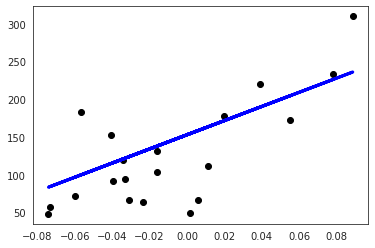

In [106]:
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_predict, color='blue', linewidth=3)

### Regression of historical GDP vs Disposable Income

In [107]:
regr = linear_model.LinearRegression()

In [108]:
regr.fit(econ_df['GDP'].to_numpy().reshape(-1,1),econ_df['disposable income'])

LinearRegression()

In [109]:
disp_income_predict = regr.predict(econ_df['GDP'].to_numpy().reshape(-1,1))

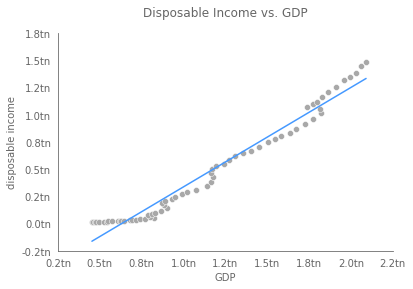

In [110]:
#plt.scatter(econ_df['GDP'].to_numpy().reshape(-1,1),econ_df['disposable income'],color='black')
#plt.plot(econ_df['GDP'].to_numpy().reshape(-1,1), disp_income_predict, color='blue', linewidth=3)

sns.scatterplot(x=econ_df['GDP'],
                y=econ_df['disposable income'],
                color=non_accent_dark)
ax = sns.lineplot(x=econ_df['GDP'],
             y=disp_income_predict,
            color=accent)

format_chart_axes("Disposable Income vs. GDP",
                  ax,
                  x_label_scale=1000000,
                  x_label_format='{:,.1f}tn',
                  y_label_scale=1000000,
                  y_label_format='{:,.1f}tn',
                  color=axis_color)

In [111]:
r2 = round(r2_score(econ_df['disposable income'],disp_income_predict),2)
intercept = humanize.intcomma(regr.intercept_,1)
coefficient = humanize.intcomma(regr.coef_[0],2)

##### Disposable Income vs GDP

Disposable Income = {{intercept}} + {{coefficient}} * GDP

The regression has an R2 of {{r2}} 

### Historical behaviour: GDP YoY change

In [112]:
used = np.random.normal(GDP_mean, GDP_std_dev, 500)

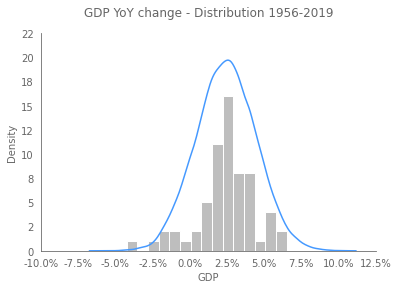

In [113]:
ax = sns.kdeplot(np.random.normal(GDP_mean, GDP_std_dev, 25000),
                  color=accent)
ax = sns.histplot(hist_df['GDP'].pct_change(),
                  bins=15,
                  color=non_accent_dark)
format_chart_axes("GDP YoY change - Distribution 1956-2019",
                  ax,
                  x_label_format='{:,.1%}',
                  y_label_format='{:,.0f}',
                  color=axis_color)

In [114]:
gdp_yoy_change_mean = '{:.2%}'.format(hist_df['GDP'].pct_change().mean())

In [115]:
gdp_yoy_change_stdev = '{:.2%}'.format(hist_df['GDP'].pct_change().std())

##### GDP YoY change historical behaviour (1956-2019)

Average YoY GDP change {{gdp_yoy_change_mean}}

Yoy GDP change Standard Deviation {{gdp_yoy_change_stdev}}

### Historical behaviour: TNL market share change

In [116]:
hist_df.tail(12)
tnl_share = hist_df['TNL GGY']/hist_df['disposable income']
tnl_share_yoy_change_mean = tnl_share.pct_change().mean()
tnl_share_yoy_change_stdev = tnl_share.pct_change().std()


In [117]:
tnl_share_yoy_change_mean

0.0003997407239658791

### Test

<AxesSubplot:xlabel='TNL GGY'>

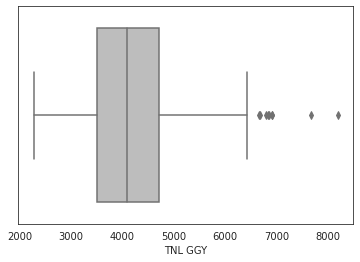

In [118]:
sns.boxplot(x=projections_df.loc[2028]['TNL GGY'],color=non_accent_medium)

[Text(0.5, 0, '')]

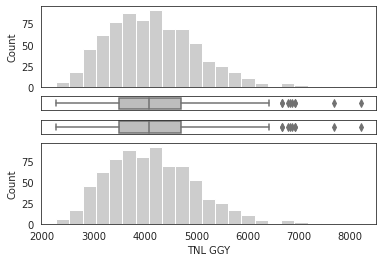

In [128]:
#Cut the window in 2 parts
f, (ax_hist1, ax_box1, ax_box2, ax_hist2) = plt.subplots(4, sharex=True, gridspec_kw={"height_ratios": (.85, .15, .15, .85)})
 
# Add a graph in each part
sns.boxplot(x=projections_df.loc[2028]['TNL GGY'],color=non_accent_medium, ax=ax_box1)
sns.histplot(x=projections_df.loc[2028]['TNL GGY'],color=non_accent_medium, ax=ax_hist1)
sns.boxplot(x=projections_df.loc[2028]['TNL GGY'],color=non_accent_medium, ax=ax_box2)
sns.histplot(x=projections_df.loc[2028]['TNL GGY'],color=non_accent_medium, ax=ax_hist2)


# Remove x axis name for the boxplot
ax_box1.set(xlabel='')
ax_box2.set(xlabel='')

In [120]:
projections_df.loc[2028]['TNL GGY'].describe()

count     750.000000
mean     4141.015627
std       868.061522
min      2271.514954
25%      3502.571166
50%      4079.328927
75%      4703.674567
max      8197.837359
Name: TNL GGY, dtype: float64

count     750.000000
mean     4138.199088
std       829.323633
min      2209.756714
25%      3525.595487
50%      4087.380672
75%      4669.786221
max      7069.350202
Name: TNL GGY, dtype: float64